In [1]:
# Dependencies

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pylab as plt
%matplotlib inline

# import seaborn as sns
# sns.set(font_scale=1.5)

In [2]:
# Import modules for feature engineering and modelling
from sklearn.model_selection import train_test_split  # not used here, split based on provider
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# for integer encoding using sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn import metrics 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve  


from sklearn.metrics import precision_recall_curve
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html

from sklearn.metrics import auc,plot_precision_recall_curve
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html

from sklearn.metrics import roc_curve,auc,RocCurveDisplay

# Set seed for reproducibility
seed1, seed2, seed3=101,67, 42

## Load and Merge Raw Data

In [3]:
# load the data from csv to pandas dataframe
Healthcare_Provider_raw = pd.read_csv("data/Train-1542865627584.csv")
Healthcare_Beneficiary_raw = pd.read_csv("data/Train_Beneficiarydata-1542865627584.csv")
Healthcare_Inpatient_raw = pd.read_csv("data/Train_Inpatientdata-1542865627584.csv")
Healthcare_Outpatient_raw = pd.read_csv("data/Train_Outpatientdata-1542865627584.csv")

In [4]:
# Assign inpatient data as 1, outpatient data as 0
Healthcare_Inpatient_raw['In_Out']=1
Healthcare_Outpatient_raw['In_Out']=0

# union/concat the inpatient and outpatient data
concat_df=pd.concat([Healthcare_Inpatient_raw,Healthcare_Outpatient_raw],axis=0)

# left join tables
merge_bene_df=concat_df.merge(Healthcare_Beneficiary_raw, on='BeneID', how='left')
merge_provider_df=merge_bene_df.merge(Healthcare_Provider_raw, on = 'Provider', how ='left')
merge_provider_df.drop_duplicates(inplace=True)

# remove columns with all null values
merge_provider_df.dropna(axis=1, how='all',inplace=True)

# drop ClaimID since it behaves as index
merge_provider_df.drop('ClaimID',axis=1, inplace=True)

# check the final merged dataframe
merge_provider_df

,BeneID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,...,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud
0,BENE11001,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,...,1,1,2,1,1,36000,3204,60,70,Yes
1,BENE11001,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,...,1,1,2,1,1,36000,3204,60,70,No
2,BENE11001,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,29590,...,1,1,2,1,1,36000,3204,60,70,No
3,BENE11011,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,431,...,1,2,2,1,1,5000,1068,250,320,No
4,BENE11014,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,78321,...,2,1,2,2,2,21260,2136,120,100,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,BENE159198,2009-08-06,2009-08-06,PRV53699,800,PHY364188,PHY364188,PHY385752,NaN,NaN,...,1,2,2,1,2,0,0,5470,1870,No
558207,BENE159198,2009-08-29,2009-08-29,PRV53702,400,PHY423019,PHY332284,NaN,NaN,NaN,...,1,2,2,1,2,0,0,5470,1870,No
558208,BENE159198,2009-09-24,2009-09-24,PRV53676,60,PHY361063,NaN,NaN,NaN,NaN,...,1,2,2,1,2,0,0,5470,1870,No
558209,BENE159198,2009-10-18,2009-10-18,PRV53689,70,PHY403198,NaN,PHY419379,NaN,NaN,...,1,2,2,1,2,0,0,5470,1870,No


In [14]:
# seperate columns into target, num, datetime, categorical
target=['PotentialFraud']

datetime_col_list=['ClaimStartDt','ClaimEndDt','AdmissionDt','DischargeDt','DOB','DOD']

diagnosis_code_columns = [x for x in list(merge_provider_df.columns) if 'ClmDiag' in x]
procedure_code_columns = [x for x in list(merge_provider_df.columns) if 'ClmProc' in x]
physican_columns = [x for x in list(merge_provider_df.columns) if 'Physician' in x]
Chronic_columns = [x for x in list(merge_provider_df.columns) if 'ChronicCond' in x]
Amt_columns=[x for x in list(merge_provider_df.columns) if 'Amt' in x]
NoOfMonths_columns=[x for x in list(merge_provider_df.columns) if 'NoOfMonth' in x]

In [15]:
colnames=merge_provider_df.columns.to_list()

cat_col_list=list(set(colnames)
                  -set(Amt_columns)-set(NoOfMonths_columns)
                  -set(target)-set(datetime_col_list)-{'In_Out','Provider'})

cat_nunique=merge_provider_df[cat_col_list].nunique()
cat_binary_list=list(cat_nunique[cat_nunique==2].index)
cat_dummy_list=list(cat_nunique[cat_nunique!=2].index)
# cat_dummy_list.sort()

# cat_dummy_list

In [20]:
agg_col_names=merge_provider_df.columns.tolist()
agg_col_names.remove('Provider')
agg_col_names.remove('PotentialFraud')


In [80]:
provider_stat_df=Healthcare_Provider_raw.copy()

In [81]:
for column_name in agg_col_names:
    for stat_method in ['mean','median','max','sum','count','nunique']:
        try:
            grouped_df=merge_provider_df.groupby('Provider').agg({column_name:stat_method})
            provider_stat_df[column_name+'_'+stat_method]=grouped_df.iloc[:,0:1].values
        except:
            1+1

BeneID mean
BeneID median
ClaimStartDt mean
ClaimStartDt median
ClaimEndDt mean
ClaimEndDt median
AttendingPhysician mean
AttendingPhysician median
AttendingPhysician max
OperatingPhysician mean
OperatingPhysician median
OperatingPhysician max
OtherPhysician mean
OtherPhysician median
OtherPhysician max
AdmissionDt mean
AdmissionDt median
AdmissionDt max
ClmAdmitDiagnosisCode mean
ClmAdmitDiagnosisCode median
ClmAdmitDiagnosisCode max
DischargeDt mean
DischargeDt median
DischargeDt max
DiagnosisGroupCode mean
DiagnosisGroupCode median
DiagnosisGroupCode max


C:\Users\pucke\.conda\envs\sklearn-env\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\pucke\.conda\envs\sklearn-env\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\pucke\.conda\envs\sklearn-env\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\pucke\.conda\envs\sklearn-env\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\pucke\.conda\envs\sklearn-env\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\pucke\.conda\envs\sklearn-env\lib\site-packages\numpy\lib\nanfunctions.py:1215: R

ClmDiagnosisCode_1 mean
ClmDiagnosisCode_1 median
ClmDiagnosisCode_1 max
ClmDiagnosisCode_2 mean
ClmDiagnosisCode_2 median
ClmDiagnosisCode_2 max
ClmDiagnosisCode_3 mean
ClmDiagnosisCode_3 median
ClmDiagnosisCode_3 max
ClmDiagnosisCode_4 mean
ClmDiagnosisCode_4 median
ClmDiagnosisCode_4 max
ClmDiagnosisCode_5 mean
ClmDiagnosisCode_5 median
ClmDiagnosisCode_5 max
ClmDiagnosisCode_6 mean
ClmDiagnosisCode_6 median
ClmDiagnosisCode_6 max
ClmDiagnosisCode_7 mean
ClmDiagnosisCode_7 median
ClmDiagnosisCode_7 max
ClmDiagnosisCode_8 mean
ClmDiagnosisCode_8 median
ClmDiagnosisCode_8 max
ClmDiagnosisCode_9 mean
ClmDiagnosisCode_9 median
ClmDiagnosisCode_9 max
ClmDiagnosisCode_10 mean
ClmDiagnosisCode_10 median
ClmDiagnosisCode_10 max


C:\Users\pucke\.conda\envs\sklearn-env\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\pucke\AppData\Local\Temp\ipykernel_6060\568625037.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  provider_stat_df[column_name+'_'+stat_method]=grouped_df.iloc[:,0:1].values
C:\Users\pucke\AppData\Local\Temp\ipykernel_6060\568625037.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  provider_stat_df[column_name+'_'+stat_method]=grouped_

DOB mean
DOB median


C:\Users\pucke\AppData\Local\Temp\ipykernel_6060\568625037.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  provider_stat_df[column_name+'_'+stat_method]=grouped_df.iloc[:,0:1].values
C:\Users\pucke\AppData\Local\Temp\ipykernel_6060\568625037.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  provider_stat_df[column_name+'_'+stat_method]=grouped_df.iloc[:,0:1].values
C:\Users\pucke\AppData\Local\Temp\ipykernel_6060\568625037.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

DOD mean
DOD median
DOD max


C:\Users\pucke\.conda\envs\sklearn-env\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\pucke\AppData\Local\Temp\ipykernel_6060\568625037.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  provider_stat_df[column_name+'_'+stat_method]=grouped_df.iloc[:,0:1].values
C:\Users\pucke\AppData\Local\Temp\ipykernel_6060\568625037.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  provider_stat_df[column_name+'_'+stat_method]=grouped_

RenalDiseaseIndicator mean
RenalDiseaseIndicator median


C:\Users\pucke\AppData\Local\Temp\ipykernel_6060\568625037.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  provider_stat_df[column_name+'_'+stat_method]=grouped_df.iloc[:,0:1].values
C:\Users\pucke\AppData\Local\Temp\ipykernel_6060\568625037.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  provider_stat_df[column_name+'_'+stat_method]=grouped_df.iloc[:,0:1].values
C:\Users\pucke\AppData\Local\Temp\ipykernel_6060\568625037.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

C:\Users\pucke\AppData\Local\Temp\ipykernel_6060\568625037.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  provider_stat_df[column_name+'_'+stat_method]=grouped_df.iloc[:,0:1].values
C:\Users\pucke\AppData\Local\Temp\ipykernel_6060\568625037.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  provider_stat_df[column_name+'_'+stat_method]=grouped_df.iloc[:,0:1].values
C:\Users\pucke\AppData\Local\Temp\ipykernel_6060\568625037.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

C:\Users\pucke\AppData\Local\Temp\ipykernel_6060\568625037.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  provider_stat_df[column_name+'_'+stat_method]=grouped_df.iloc[:,0:1].values
C:\Users\pucke\AppData\Local\Temp\ipykernel_6060\568625037.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  provider_stat_df[column_name+'_'+stat_method]=grouped_df.iloc[:,0:1].values
C:\Users\pucke\AppData\Local\Temp\ipykernel_6060\568625037.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

C:\Users\pucke\AppData\Local\Temp\ipykernel_6060\568625037.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  provider_stat_df[column_name+'_'+stat_method]=grouped_df.iloc[:,0:1].values
C:\Users\pucke\AppData\Local\Temp\ipykernel_6060\568625037.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  provider_stat_df[column_name+'_'+stat_method]=grouped_df.iloc[:,0:1].values
C:\Users\pucke\AppData\Local\Temp\ipykernel_6060\568625037.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

C:\Users\pucke\AppData\Local\Temp\ipykernel_6060\568625037.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  provider_stat_df[column_name+'_'+stat_method]=grouped_df.iloc[:,0:1].values
C:\Users\pucke\AppData\Local\Temp\ipykernel_6060\568625037.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  provider_stat_df[column_name+'_'+stat_method]=grouped_df.iloc[:,0:1].values
C:\Users\pucke\AppData\Local\Temp\ipykernel_6060\568625037.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

C:\Users\pucke\AppData\Local\Temp\ipykernel_6060\568625037.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  provider_stat_df[column_name+'_'+stat_method]=grouped_df.iloc[:,0:1].values


In [82]:
df_raw=provider_stat_df.select_dtypes(include=np.number).copy()
df_raw

,BeneID_count,BeneID_nunique,ClaimStartDt_count,ClaimStartDt_nunique,ClaimEndDt_count,ClaimEndDt_nunique,InscClaimAmtReimbursed_mean,InscClaimAmtReimbursed_median,InscClaimAmtReimbursed_max,InscClaimAmtReimbursed_sum,...,OPAnnualReimbursementAmt_max,OPAnnualReimbursementAmt_sum,OPAnnualReimbursementAmt_count,OPAnnualReimbursementAmt_nunique,OPAnnualDeductibleAmt_mean,OPAnnualDeductibleAmt_median,OPAnnualDeductibleAmt_max,OPAnnualDeductibleAmt_sum,OPAnnualDeductibleAmt_count,OPAnnualDeductibleAmt_nunique
0,25,24,25,23,25,25,4185.600000,400.0,42000,104640,...,13460,65380,25,24,463.920000,150.0,2700,11598,25,20
1,132,117,132,111,132,112,4588.409091,1750.0,57000,605670,...,31880,353520,132,97,737.121212,210.0,9950,97300,132,69
2,149,138,149,117,149,115,350.134228,70.0,3300,52170,...,20900,327040,149,116,622.751678,380.0,7410,92790,149,78
3,1165,495,1165,356,1165,354,241.124464,70.0,4080,280910,...,97510,2457840,1165,256,636.328755,360.0,6330,741323,1165,141
4,72,58,72,68,72,66,468.194444,80.0,10000,33710,...,6060,124540,72,50,469.722222,240.0,1970,33820,72,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,28,24,28,27,28,27,380.000000,65.0,3300,10640,...,14650,90770,28,22,886.785714,510.0,2810,24830,28,23
5406,22,9,22,22,22,22,216.818182,85.0,1100,4770,...,4980,32840,22,9,805.454545,620.0,2930,17720,22,8
5407,82,67,82,76,82,78,225.243902,70.0,2200,18470,...,25090,240130,82,60,707.317073,340.0,4940,58000,82,51
5408,1,1,1,1,1,1,1900.000000,1900.0,1900,1900,...,2540,2540,1,1,400.000000,400.0,400,400,1,1


In [83]:
df_raw=pd.concat([Healthcare_Provider_raw,df_raw],axis=1)
df_raw

,Provider,PotentialFraud,BeneID_count,BeneID_nunique,ClaimStartDt_count,ClaimStartDt_nunique,ClaimEndDt_count,ClaimEndDt_nunique,InscClaimAmtReimbursed_mean,InscClaimAmtReimbursed_median,...,OPAnnualReimbursementAmt_max,OPAnnualReimbursementAmt_sum,OPAnnualReimbursementAmt_count,OPAnnualReimbursementAmt_nunique,OPAnnualDeductibleAmt_mean,OPAnnualDeductibleAmt_median,OPAnnualDeductibleAmt_max,OPAnnualDeductibleAmt_sum,OPAnnualDeductibleAmt_count,OPAnnualDeductibleAmt_nunique
0,PRV51001,No,25,24,25,23,25,25,4185.600000,400.0,...,13460,65380,25,24,463.920000,150.0,2700,11598,25,20
1,PRV51003,Yes,132,117,132,111,132,112,4588.409091,1750.0,...,31880,353520,132,97,737.121212,210.0,9950,97300,132,69
2,PRV51004,No,149,138,149,117,149,115,350.134228,70.0,...,20900,327040,149,116,622.751678,380.0,7410,92790,149,78
3,PRV51005,Yes,1165,495,1165,356,1165,354,241.124464,70.0,...,97510,2457840,1165,256,636.328755,360.0,6330,741323,1165,141
4,PRV51007,No,72,58,72,68,72,66,468.194444,80.0,...,6060,124540,72,50,469.722222,240.0,1970,33820,72,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,No,28,24,28,27,28,27,380.000000,65.0,...,14650,90770,28,22,886.785714,510.0,2810,24830,28,23
5406,PRV57760,No,22,9,22,22,22,22,216.818182,85.0,...,4980,32840,22,9,805.454545,620.0,2930,17720,22,8
5407,PRV57761,No,82,67,82,76,82,78,225.243902,70.0,...,25090,240130,82,60,707.317073,340.0,4940,58000,82,51
5408,PRV57762,No,1,1,1,1,1,1,1900.000000,1900.0,...,2540,2540,1,1,400.000000,400.0,400,400,1,1


In [84]:
df_raw['PotentialFraud']=df_raw['PotentialFraud'].map(lambda x:1 if (x=='Yes' or x==1) else 0)
df_raw

,Provider,PotentialFraud,BeneID_count,BeneID_nunique,ClaimStartDt_count,ClaimStartDt_nunique,ClaimEndDt_count,ClaimEndDt_nunique,InscClaimAmtReimbursed_mean,InscClaimAmtReimbursed_median,...,OPAnnualReimbursementAmt_max,OPAnnualReimbursementAmt_sum,OPAnnualReimbursementAmt_count,OPAnnualReimbursementAmt_nunique,OPAnnualDeductibleAmt_mean,OPAnnualDeductibleAmt_median,OPAnnualDeductibleAmt_max,OPAnnualDeductibleAmt_sum,OPAnnualDeductibleAmt_count,OPAnnualDeductibleAmt_nunique
0,PRV51001,0,25,24,25,23,25,25,4185.600000,400.0,...,13460,65380,25,24,463.920000,150.0,2700,11598,25,20
1,PRV51003,1,132,117,132,111,132,112,4588.409091,1750.0,...,31880,353520,132,97,737.121212,210.0,9950,97300,132,69
2,PRV51004,0,149,138,149,117,149,115,350.134228,70.0,...,20900,327040,149,116,622.751678,380.0,7410,92790,149,78
3,PRV51005,1,1165,495,1165,356,1165,354,241.124464,70.0,...,97510,2457840,1165,256,636.328755,360.0,6330,741323,1165,141
4,PRV51007,0,72,58,72,68,72,66,468.194444,80.0,...,6060,124540,72,50,469.722222,240.0,1970,33820,72,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,0,28,24,28,27,28,27,380.000000,65.0,...,14650,90770,28,22,886.785714,510.0,2810,24830,28,23
5406,PRV57760,0,22,9,22,22,22,22,216.818182,85.0,...,4980,32840,22,9,805.454545,620.0,2930,17720,22,8
5407,PRV57761,0,82,67,82,76,82,78,225.243902,70.0,...,25090,240130,82,60,707.317073,340.0,4940,58000,82,51
5408,PRV57762,0,1,1,1,1,1,1,1900.000000,1900.0,...,2540,2540,1,1,400.000000,400.0,400,400,1,1


In [85]:
test_provider_df = pd.read_csv("output/agg_train_test_split/test_provider_list.csv")
train_provider_df = pd.read_csv("output/agg_train_test_split/train_provider_list.csv")
test_provider_list=test_provider_df['Provider']
train_provider_list=train_provider_df['Provider']

df_train=df_raw[df_raw['Provider'].isin(train_provider_list)].copy()
df_test=df_raw[df_raw['Provider'].isin(test_provider_list)].copy()

df_test.shape,df_train.shape

((1082, 222), (4328, 222))

In [86]:
y_train=df_train['PotentialFraud'].copy()
y_test=df_test['PotentialFraud'].copy()

features=df_raw.columns

X_train=df_train[features[2:]].fillna(0)
X_test=df_test[features[2:]].fillna(0)

## Load the Splitted Provider Level Data

In [87]:
import xgboost as xgb
from sklearn.svm import SVC

xgb_cl = xgb.XGBClassifier()

classification_models={
#     'LogisticRegression':LogisticRegression(class_weight = 'balanced',random_state=seed1,max_iter=10000),
#     'RandomForest':RandomForestClassifier(n_estimators = 5, random_state = seed1),
    'XGBClassifier':xgb.XGBClassifier(n_estimators = 5,random_state = seed1),
#     'SVC': SVC()
}

Training Accuracy Score: 0.966
Testinging Accuracy Score: 0.933
---------------------Train Classification Report--------------------------------

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3925
           1       0.97      0.66      0.79       403

    accuracy                           0.97      4328
   macro avg       0.97      0.83      0.88      4328
weighted avg       0.97      0.97      0.96      4328

---------------------Test Classification Report--------------------------------

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       979
           1       0.72      0.50      0.59       103

    accuracy                           0.93      1082
   macro avg       0.83      0.74      0.78      1082
weighted avg       0.93      0.93      0.93      1082

roc_auc_score for the train dataset: 0.98
roc_auc_score for the test dataset: 0.94


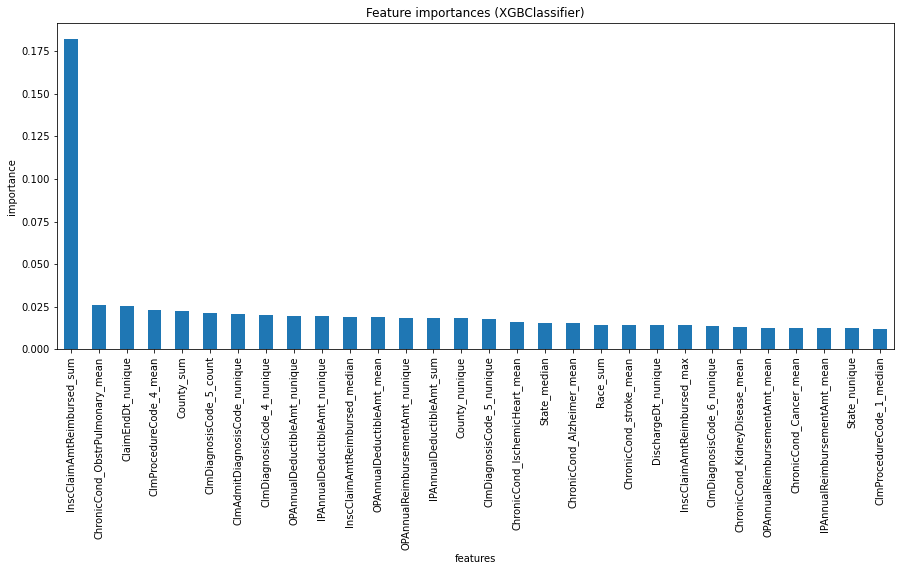

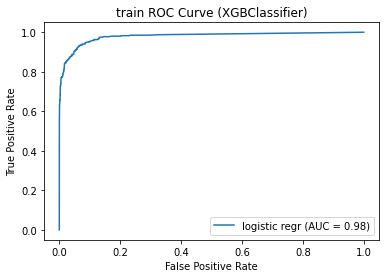

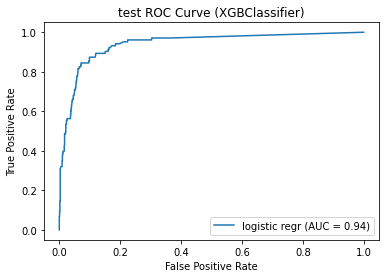

PR-AUC is 0.91


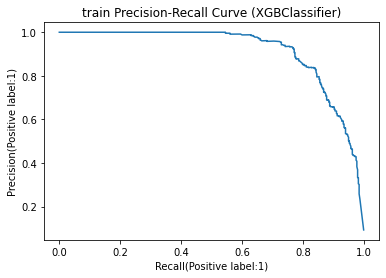

PR-AUC is 0.69


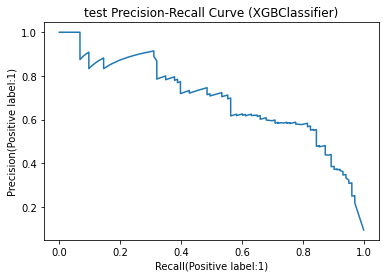

In [88]:
# use StandardScaler and Classification to build a classification pipeline.

classfication_pipeline={}

for key,value in classification_models.items():

    classfication_pipeline[key] = Pipeline([
        #('preprocessor',preprocessor),
        ('rescale', StandardScaler()),
        ('clf', value)
    ])
    
    classfication_pipeline[key]=classfication_pipeline[key].fit(X_train, y_train)
    
    
    # Use the predict function of the model to make predictions for the training set and test set,
    # and assign the outputs to y_train_pred and y_test_pred, respectively.

    y_train_pred = classfication_pipeline[key].predict(X_train)
    y_test_pred = classfication_pipeline[key].predict(X_test)
    
    
    print('Training Accuracy Score: {0:.3f}'.format(accuracy_score(y_train, y_train_pred)))
    print('Testinging Accuracy Score: {0:.3f}'.format(accuracy_score(y_test, y_test_pred)))
    
    
    print('---------------------Train Classification Report--------------------------------\n')
    print(classification_report(y_train, y_train_pred))
    print('---------------------Test Classification Report--------------------------------\n')
    print(classification_report(y_test, y_test_pred))

    
    
    try:
        importances=classfication_pipeline[key][1].feature_importances_
    except:
        importances=classfication_pipeline[key][1].coef_[0]
    feature_names=classfication_pipeline[key].feature_names_in_

    pd_Series_importances = (pd.Series(importances, index=feature_names)).sort_values(ascending=False)

    fig = plt.figure(figsize=(15,6))
    pd_Series_importances[:30].plot.bar()
    plt.title("Feature importances (XGBClassifier)")
    plt.ylabel("importance")
    plt.xlabel("features")
    plt.show()
    
    
    roc_auc_score_train = roc_auc_score(y_train, classfication_pipeline[key].predict_proba(X_train)[:, 1])  
    roc_auc_score_test = roc_auc_score(y_test, classfication_pipeline[key].predict_proba(X_test)[:, 1])
    print('roc_auc_score for the train dataset: {:.2f}'.format(roc_auc_score_train))
    print('roc_auc_score for the test dataset: {:.2f}'.format(roc_auc_score_test))    
    
    
    y_train_proba=classfication_pipeline[key].predict_proba(X_train)
    fpr, tpr, thresholds = roc_curve(y_train, y_train_proba[:,1])
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                      estimator_name='logistic regr')
    display.plot()

    plt.title(f'train ROC Curve ({key})')
    plt.show()
    
   
    y_test_proba=classfication_pipeline[key].predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                      estimator_name='logistic regr')
    display.plot()

    plt.title(f'test ROC Curve ({key})')
    plt.show()
    
    
    y_score = y_train_proba[:, 1]

    # Data to plot precision - recall curve
    precision, recall, thresholds = precision_recall_curve(y_train, y_score)
    # Use AUC function to calculate the area under the curve of precision recall curve
    auc_precision_recall = auc(recall, precision)
    print('PR-AUC is {:.2f}'.format(auc_precision_recall))

    # plot PR curve
    plt.plot(recall, precision)
    plt.xlabel('Recall(Positive label:1)')
    plt.ylabel('Precision(Positive label:1)')
    plt.title(f'train Precision-Recall Curve ({key})')
    plt.show()
    
    y_score = y_test_proba[:, 1]

    # Data to plot precision - recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    # Use AUC function to calculate the area under the curve of precision recall curve
    auc_precision_recall = auc(recall, precision)
    print('PR-AUC is {:.2f}'.format(auc_precision_recall))

    # plot PR curve
    plt.plot(recall, precision)
    plt.xlabel('Recall(Positive label:1)')
    plt.ylabel('Precision(Positive label:1)')
    plt.title(f'test Precision-Recall Curve ({key})')
    plt.show()

In [89]:
y_score = y_train_proba[:, 1]

# Data to plot precision - recall curve
precision, recall, thresholds = precision_recall_curve(y_train, y_score)

train_pr_df=pd.DataFrame({'precision':precision[:-1], 'recall':recall[:-1], 'thresholds':thresholds})

In [90]:
len(precision), len(recall), len(thresholds)

(720, 720, 719)

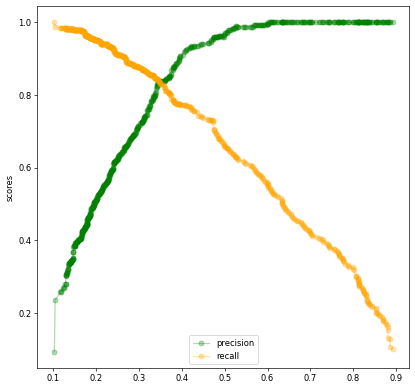

In [91]:
fig = plt.figure(figsize=(8,8),dpi=60)
plt.plot(train_pr_df.thresholds,train_pr_df.precision,'o-',color='green',label='precision',alpha=0.3)
plt.plot(train_pr_df.thresholds,train_pr_df.recall,'o-',color='orange',label='recall',alpha=0.3)
plt.legend(loc='lower center')
plt.ylabel('scores')
plt.show()

In [92]:
y_score = y_test_proba[:, 1]

# Data to plot precision - recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

test_pr_df=pd.DataFrame({'precision':precision[:-1], 'recall':recall[:-1], 'thresholds':thresholds})

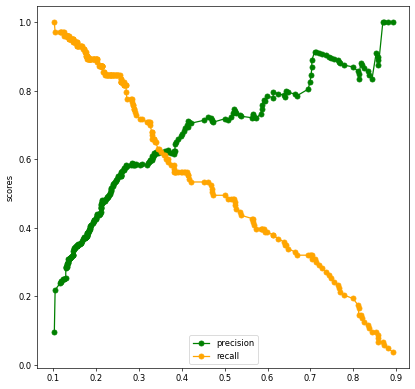

In [93]:
fig = plt.figure(figsize=(8,8),dpi=60)
plt.plot(test_pr_df.thresholds,test_pr_df.precision,'o-',color='green',label='precision')
plt.plot(test_pr_df.thresholds,test_pr_df.recall,'o-',color='orange',label='recall')
plt.legend(loc='lower center')
plt.ylabel('scores')
plt.show()